In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import hamiltonian_monte_carlo as hmc
import diagnostics
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import pickle

In [4]:
def two_d_mixture_gaussians(theta):
    return hmc.np.log(0.5 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([2, 12]),
                                                          cov=hmc.np.array(([[2, 0.5], [0.5, 1]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([10, -8]),
                                                           cov=hmc.np.array(([[1, 0.9], [0.9, 2]]))) + \
                  0.25 * hmc.stats.multivariate_normal.pdf(theta, mean=hmc.np.array([-12, -9]),
                                                           cov=hmc.np.array(([[0.5, 0], [0, 0.5]]))))

In [3]:
DEFAULT_COLORMAP = 'Paired'


def sample_and_plot(sample_generating_function, num_chains, log_density,
                    first_param_limits, second_param_limits, suptitle='', 
                    temperature=1.0, warmup_proportion=0.5, colormap_name=DEFAULT_COLORMAP):
    all_samples = []
    all_theta_samples = []
    
    for i in range(num_chains):
        samples = sample_generating_function()
        all_samples.append(np.copy(samples))
        theta_samples = np.stack(np.ndarray.flatten(samples[:, 0]))
        all_theta_samples.append(np.copy(theta_samples))
        
    two_d_countour_plot(log_density, num_chains, first_param_limits, second_param_limits,
                        all_samples, all_theta_samples, suptitle, 
                        warmup_proportion, temperature, colormap_name)
    
    return all_samples, all_theta_samples


def two_d_countour_plot(log_density, num_chains, first_param_limits, second_param_limits,
                        all_samples, all_theta_samples, suptitle='', warmup_propotion=0.5,
                        temperature=1.0, colormap_name=DEFAULT_COLORMAP):
    theta_one_values = np.linspace(first_param_limits[0], first_param_limits[1], 100)
    theta_two_values = np.linspace(second_param_limits[0], second_param_limits[1], 100)
    
    theta_one_grid, theta_two_grid = np.meshgrid(theta_one_values, theta_two_values)
    theta_grid = np.stack((theta_one_grid, theta_two_grid), axis=2)
    contour_values = log_density(theta_grid) / temperature
    
    plt.figure(figsize=(12, 12))
    plt.contour(theta_one_grid, theta_two_grid, contour_values, 30)
    
    if num_chains > 0:    
        real_sample_start = int(all_theta_samples[0].shape[0] * warmup_propotion)
        colormap = plt.get_cmap(colormap_name)
        
        for i in range(num_chains):
            sample_colors = all_samples[i][:,2].astype(np.int32) + (2 * i)
            sample_colors = [colormap.colors[x] for x in sample_colors]
            plt.scatter(all_theta_samples[i][real_sample_start:,0], 
                        all_theta_samples[i][real_sample_start:,1], 
                        c=sample_colors[real_sample_start:], label=f'Chain #{i+1}')

        legend = plt.legend(loc='best')
        for i in range(num_chains):
            legend.legendHandles[i].set_color(colormap.colors[(2 * i) + 1])

        theta_samples = np.asarray(all_theta_samples)[:, real_sample_start:, :]
        ess = diagnostics.effective_sample_size(theta_samples)
        rhat = diagnostics.split_r_hat(theta_samples)

        with np.printoptions(precision=5, suppress=True):
            plt.title(f'Sampling results, {all_theta_samples[0].shape[0] - real_sample_start} post-warm-up samples, ESS = {ess}, $\\hat{{R}}$ = {rhat}')
    
    plt.suptitle(suptitle, size=20, y=0.93)
    
    plt.show()

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 1.0


/Users/guydavidson/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:76: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/autograd/scipy/stats/multivariate_normal.py:50: RuntimeWarning: invalid value encountered in double_scalars
  unbroadcast_f(x, lambda g: -np.expand_dims(ans * g, 1) * solve(allow_singular)(cov, (x - mean).T).T),


Sampled 100 iterations of which 62 were accepted


/Users/guydavidson/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:76: RuntimeWarning: overflow encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)


Sampled 200 iterations of which 128 were accepted
Sampled 300 iterations of which 196 were accepted
Sampled 400 iterations of which 258 were accepted
Sampled 500 iterations of which 323 were accepted
Sampled 600 iterations of which 396 were accepted
Sampled 700 iterations of which 461 were accepted
Sampled 800 iterations of which 530 were accepted
Sampled 900 iterations of which 606 were accepted
Sampled 1000 iterations of which 675 were accepted
Sampled 1100 iterations of which 741 were accepted
Sampled 1200 iterations of which 794 were accepted
Sampled 1300 iterations of which 848 were accepted
Sampled 1400 iterations of which 912 were accepted
Sampled 1500 iterations of which 973 were accepted
Sampled 1600 iterations of which 1034 were accepted
Sampled 1700 iterations of which 1101 were accepted
Sampled 1800 iterations of which 1161 were accepted
Sampled 1900 iterations of which 1213 were accepted
HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 1.0
Sampled 

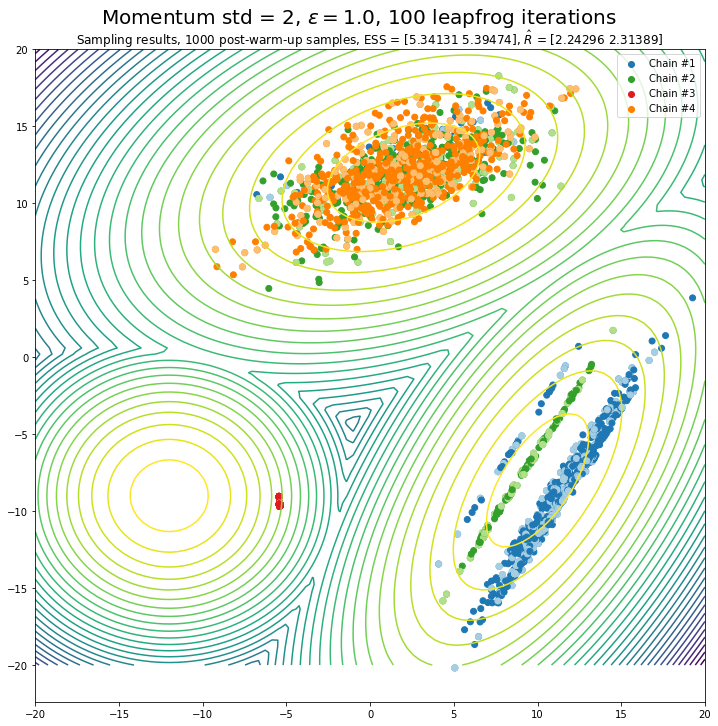

In [6]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

epsilon =  1.0
leapfrog = 100
momentum_std = 5.0

def sample():
    return hmc.hamiltonian_monte_carlo(two_d_mixture_gaussians, theta_0_sampler(), 
                                       epsilon, leapfrog, 2000, 2, momentum_std=momentum_std, 
                                       log_interval=100)

all_samples, all_theta_samples = \
    sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                   f'Momentum std = 2, $\\epsilon = {epsilon}$, {leapfrog} leapfrog iterations')

with open('results.pickle', 'rb') as f:
        results = pickle.load(f)
        
results['HMC', epsilon, leapfrog, momentum_std] = all_samples, all_theta_samples

with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

## Just out of curiosity, what happens for vastly smaller epsilons?

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.1
Sampled 100 iterations of which 95 were accepted
Sampled 200 iterations of which 186 were accepted
Sampled 300 iterations of which 280 were accepted
Sampled 400 iterations of which 379 were accepted
Sampled 500 iterations of which 474 were accepted
Sampled 600 iterations of which 567 were accepted
Sampled 700 iterations of which 662 were accepted
Sampled 800 iterations of which 758 were accepted
Sampled 900 iterations of which 850 were accepted
Sampled 1000 iterations of which 946 were accepted
Sampled 1100 iterations of which 1041 were accepted
Sampled 1200 iterations of which 1132 were accepted
Sampled 1300 iterations of which 1227 were accepted
Sampled 1400 iterations of which 1322 were accepted
Sampled 1500 iterations of which 1418 were accepted
Sampled 1600 iterations of which 1512 were accepted
Sampled 1700 iterations of which 1607 were accepted
Sampled 1800 iterations of which 1705 were accepted
Sample

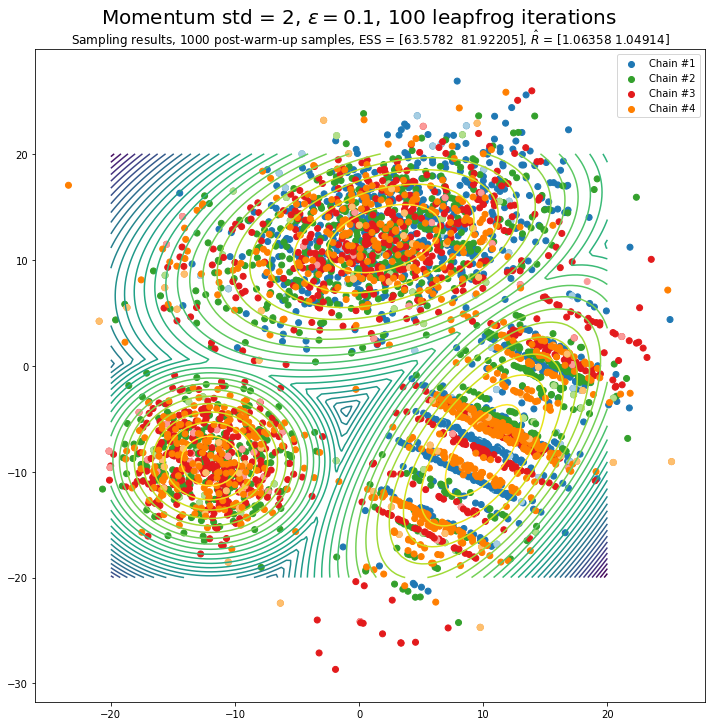

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.01
Sampled 100 iterations of which 101 were accepted
Sampled 200 iterations of which 201 were accepted
Sampled 300 iterations of which 301 were accepted
Sampled 400 iterations of which 401 were accepted
Sampled 500 iterations of which 501 were accepted
Sampled 600 iterations of which 601 were accepted
Sampled 700 iterations of which 701 were accepted
Sampled 800 iterations of which 801 were accepted
Sampled 900 iterations of which 901 were accepted
Sampled 1000 iterations of which 1001 were accepted
Sampled 1100 iterations of which 1101 were accepted
Sampled 1200 iterations of which 1201 were accepted
Sampled 1300 iterations of which 1301 were accepted
Sampled 1400 iterations of which 1401 were accepted
Sampled 1500 iterations of which 1501 were accepted
Sampled 1600 iterations of which 1601 were accepted
Sampled 1700 iterations of which 1701 were accepted
Sampled 1800 iterations of which 1801 were accepted
Sam

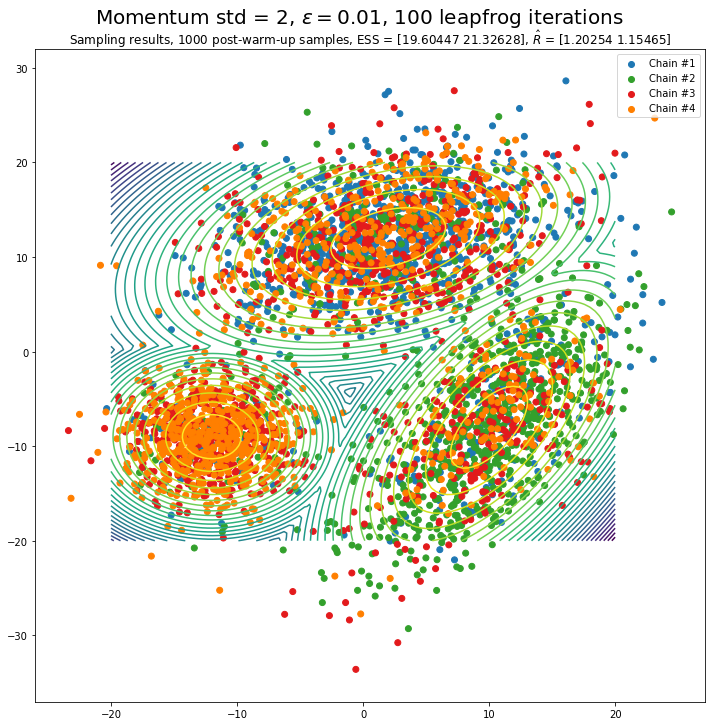

In [8]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)


leapfrog = 100
momentum_std = 5.0

for epsilon in (0.1, 0.01):
    def sample():
        return hmc.hamiltonian_monte_carlo(two_d_mixture_gaussians, theta_0_sampler(), 
                                           epsilon, leapfrog, 2000, 2, momentum_std=momentum_std, 
                                           log_interval=100)

    all_samples, all_theta_samples = \
        sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                       f'Momentum std = 2, $\\epsilon = {epsilon}$, {leapfrog} leapfrog iterations')

    with open('results.pickle', 'rb') as f:
            results = pickle.load(f)

    results['HMC', epsilon, leapfrog, momentum_std] = all_samples, all_theta_samples

    with open('results.pickle', 'wb') as f:
        pickle.dump(results, f)

## And smaller epsilons with the standard momentum $\sigma$?

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.1
Sampled 100 iterations of which 101 were accepted
Sampled 200 iterations of which 201 were accepted
Sampled 300 iterations of which 301 were accepted
Sampled 400 iterations of which 401 were accepted
Sampled 500 iterations of which 501 were accepted
Sampled 600 iterations of which 601 were accepted
Sampled 700 iterations of which 701 were accepted
Sampled 800 iterations of which 801 were accepted
Sampled 900 iterations of which 901 were accepted
Sampled 1000 iterations of which 1000 were accepted
Sampled 1100 iterations of which 1100 were accepted
Sampled 1200 iterations of which 1200 were accepted
Sampled 1300 iterations of which 1300 were accepted
Sampled 1400 iterations of which 1400 were accepted
Sampled 1500 iterations of which 1500 were accepted
Sampled 1600 iterations of which 1600 were accepted
Sampled 1700 iterations of which 1700 were accepted
Sampled 1800 iterations of which 1800 were accepted
Samp

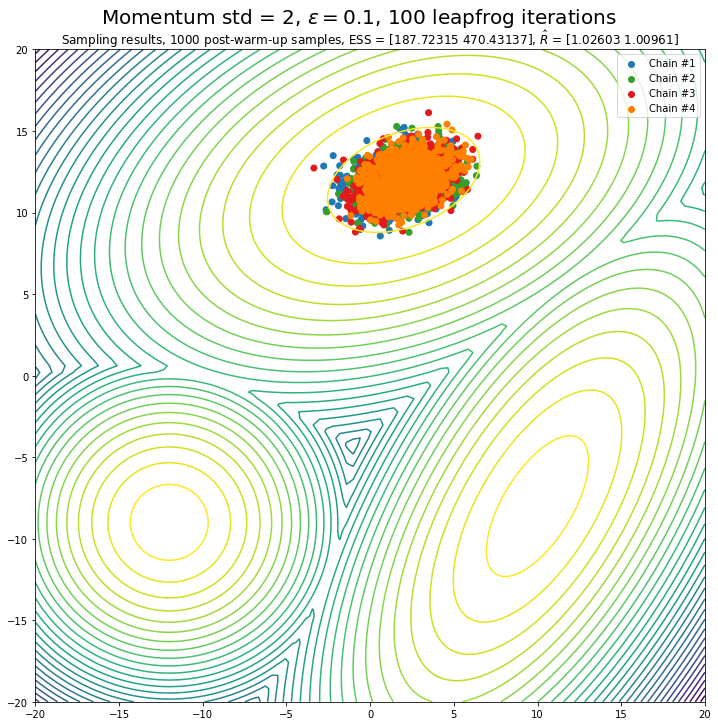

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.01
Sampled 100 iterations of which 101 were accepted
Sampled 200 iterations of which 201 were accepted
Sampled 300 iterations of which 301 were accepted
Sampled 400 iterations of which 401 were accepted
Sampled 500 iterations of which 501 were accepted
Sampled 600 iterations of which 601 were accepted
Sampled 700 iterations of which 701 were accepted
Sampled 800 iterations of which 801 were accepted
Sampled 900 iterations of which 901 were accepted
Sampled 1000 iterations of which 1001 were accepted
Sampled 1100 iterations of which 1101 were accepted
Sampled 1200 iterations of which 1201 were accepted
Sampled 1300 iterations of which 1301 were accepted
Sampled 1400 iterations of which 1401 were accepted
Sampled 1500 iterations of which 1501 were accepted
Sampled 1600 iterations of which 1601 were accepted
Sampled 1700 iterations of which 1701 were accepted
Sampled 1800 iterations of which 1801 were accepted
Sam

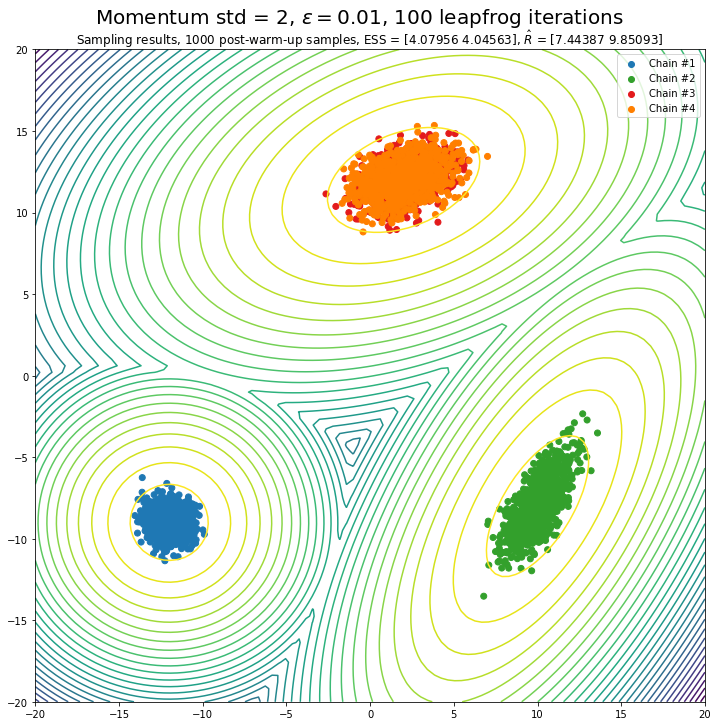

In [9]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)


leapfrog = 100
momentum_std = 1.0


for epsilon in (0.1, 0.01):
    def sample():
        return hmc.hamiltonian_monte_carlo(two_d_mixture_gaussians, theta_0_sampler(), 
                                           epsilon, leapfrog, 2000, 2, momentum_std=momentum_std, 
                                           log_interval=100)

    all_samples, all_theta_samples = \
        sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                       f'Momentum std = 2, $\\epsilon = {epsilon}$, {leapfrog} leapfrog iterations')

    with open('results.pickle', 'rb') as f:
            results = pickle.load(f)

    results['HMC', epsilon, leapfrog, momentum_std] = all_samples, all_theta_samples

    with open('results.pickle', 'wb') as f:
        pickle.dump(results, f)

Okay, so with a momentum std of one we're still bad. Above we were at five, which was sufficient. 

Let's find a happier middle?

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.1
Sampled 100 iterations of which 99 were accepted
Sampled 200 iterations of which 199 were accepted
Sampled 300 iterations of which 299 were accepted
Sampled 400 iterations of which 398 were accepted
Sampled 500 iterations of which 498 were accepted
Sampled 600 iterations of which 598 were accepted
Sampled 700 iterations of which 696 were accepted
Sampled 800 iterations of which 796 were accepted
Sampled 900 iterations of which 896 were accepted
Sampled 1000 iterations of which 995 were accepted
Sampled 1100 iterations of which 1095 were accepted
Sampled 1200 iterations of which 1195 were accepted
Sampled 1300 iterations of which 1294 were accepted
Sampled 1400 iterations of which 1394 were accepted
Sampled 1500 iterations of which 1494 were accepted
Sampled 1600 iterations of which 1594 were accepted
Sampled 1700 iterations of which 1694 were accepted
Sampled 1800 iterations of which 1793 were accepted
Sample

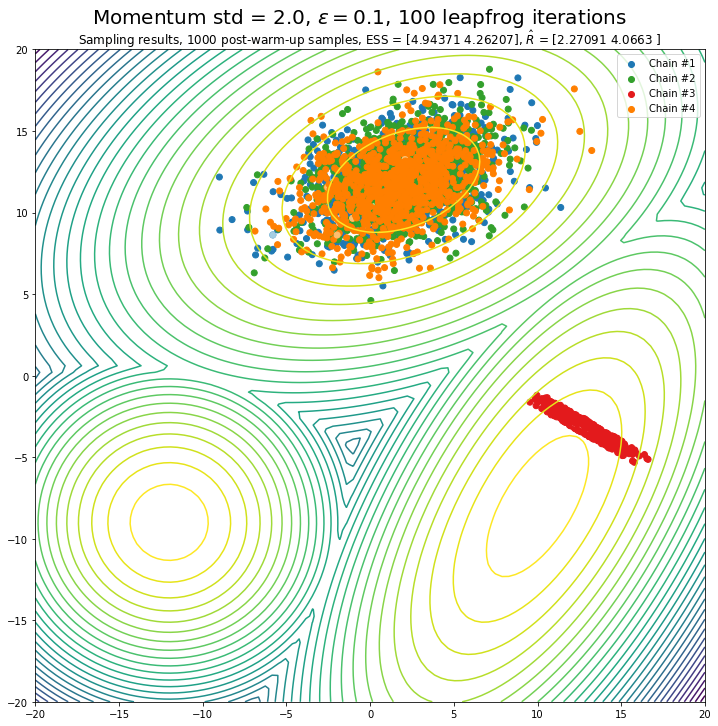

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.1
Sampled 100 iterations of which 96 were accepted
Sampled 200 iterations of which 194 were accepted
Sampled 300 iterations of which 293 were accepted
Sampled 400 iterations of which 390 were accepted
Sampled 500 iterations of which 490 were accepted
Sampled 600 iterations of which 590 were accepted
Sampled 700 iterations of which 689 were accepted
Sampled 800 iterations of which 786 were accepted
Sampled 900 iterations of which 885 were accepted
Sampled 1000 iterations of which 985 were accepted
Sampled 1100 iterations of which 1083 were accepted
Sampled 1200 iterations of which 1183 were accepted
Sampled 1300 iterations of which 1282 were accepted
Sampled 1400 iterations of which 1381 were accepted
Sampled 1500 iterations of which 1481 were accepted
Sampled 1600 iterations of which 1581 were accepted
Sampled 1700 iterations of which 1681 were accepted
Sampled 1800 iterations of which 1781 were accepted
Sample

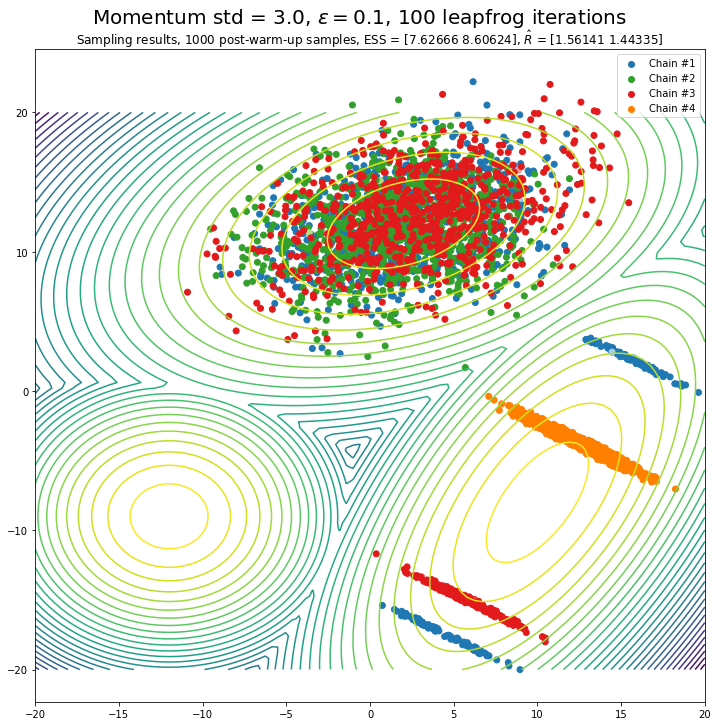

HMC: sampling 2000 iterations with 100 leapfrog iterations with epsilon = 0.1
Sampled 100 iterations of which 97 were accepted
Sampled 200 iterations of which 194 were accepted
Sampled 300 iterations of which 288 were accepted
Sampled 400 iterations of which 384 were accepted
Sampled 500 iterations of which 484 were accepted
Sampled 600 iterations of which 583 were accepted
Sampled 700 iterations of which 679 were accepted
Sampled 800 iterations of which 774 were accepted
Sampled 900 iterations of which 871 were accepted
Sampled 1000 iterations of which 967 were accepted
Sampled 1100 iterations of which 1066 were accepted
Sampled 1200 iterations of which 1161 were accepted
Sampled 1300 iterations of which 1261 were accepted
Sampled 1400 iterations of which 1360 were accepted
Sampled 1500 iterations of which 1458 were accepted
Sampled 1600 iterations of which 1556 were accepted
Sampled 1700 iterations of which 1655 were accepted
Sampled 1800 iterations of which 1755 were accepted
Sample

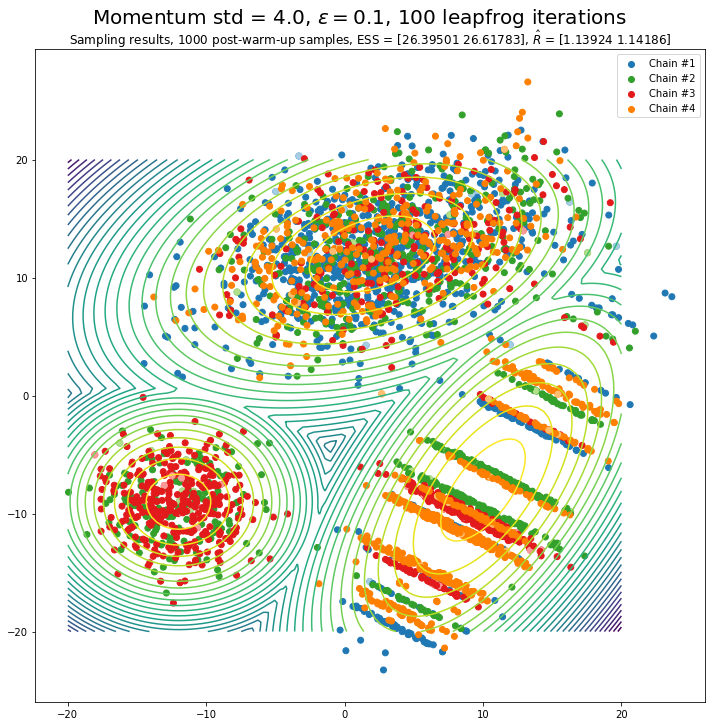

In [10]:
theta_0_sampler = lambda: np.random.uniform(-10, 10, 2)

epsilon = 0.1
leapfrog = 100

for momentum_std in (2.0, 3.0, 4.0):
    def sample():
        return hmc.hamiltonian_monte_carlo(two_d_mixture_gaussians, theta_0_sampler(), 
                                           epsilon, leapfrog, 2000, 2, momentum_std=momentum_std, 
                                           log_interval=100)

    all_samples, all_theta_samples = \
        sample_and_plot(sample, 4, two_d_mixture_gaussians, [-20, 20], [-20, 20], 
                       f'Momentum std = {momentum_std}, $\\epsilon = {epsilon}$, {leapfrog} leapfrog iterations')

    with open('results.pickle', 'rb') as f:
            results = pickle.load(f)

    results['HMC', epsilon, leapfrog, momentum_std] = all_samples, all_theta_samples

    with open('results.pickle', 'wb') as f:
        pickle.dump(results, f)